# Synthetic ice shelf

In this demo, we'll show how to simulate the evolution of a floating ice shelf.
The example that we'll show is an example of a model *spin-up*.
In a spin-up experiment, the objective is to obtain a physically plausible state of some system from an initial guess by simulating its evolution for a long time.
For example, it's common to spin up climate models from a very rough initial guess for several thousand years to obtain a representative state of the atmosphere and oceans for the epoch you're interested in.

In our case, we'll use an idealized ice shelf geometry and a rough guess for the initial ice thickness.
First we'll solve the *diagnostic equation* for the velocity througout the ice shelf.
We'll then solve the *prognostic equation* to obtain the ice thickness at a slightly later time.
By assuming a given rate of ice accumulation and melting, we can successively solve the prognostic and diagnostic equations until the system is close to a steady state.
In our case, that will take about 250 years of model time and (at least on my laptop) only a few minutes of computer time.

As with the synthetic ice sheet demo, the whole simulation can be divided into three parts:

* Define the shape of the ice shelf and get a triangulation of the interior.
* Define the initial guess for the ice thickness and velocity, and set a value of the rheology and accumulation rate.
* Set the total simulation time and the number of time steps, and then iteratively update the ice thickness and velocity at each time step.

We saw this workflow in the last demo. In later demos we'll see some variations on this procedure -- incorporating real data, comparing different physics, and so forth -- but the essential idea is the same throughout.

### Geometry

First we need to define the geometry of the ice shelf.
Although we'll be solving a synthetic problem, we'll try to use a more-or-less realistic shape.
The inflow boundary will be a circular arc centered at the origin with a radius of 200 km.
The outflow boundary will be another circular arc with a much higher radius.

In the first two demos, we used one of firedrake's built-in functions to create the geometry.
For more complicated shapes you'll need to use a mesh generator, a program that turns a description of the boundary of a spatial domain into a triangulation of the interior.
Two of the more popular 2D mesh generators are [gmsh](http://gmsh.info/) and [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).
In this case we'll use gmsh because we can create the input file entirely in Python through the package [pygmsh](https://github.com/nschloe/pygmsh).

We'll first define the mesh radius and the spacing for the mesh cells.

In [1]:
import pygmsh

R = 200e3
δx = 5e3

Next, we'll create an empty geometry and add some points to it.
The points `x1`, `x2` will represent the left and right endpoints of the mesh.
The points `center1`, `center2` will not actually be contained in the mesh, but rather define the centers of the two circular arcs.
Finally, we'll add the circular arcs.

In [2]:
geometry = pygmsh.built_in.Geometry()

x1 = geometry.add_point([-R, 0, 0], lcar=δx)
x2 = geometry.add_point([+R, 0, 0], lcar=δx)d

center1 = geometry.add_point([0, 0, 0,], lcar=δx)
center2 = geometry.add_point([0, -4 * R, 0], lcar=δx)

arcs = [
    geometry.add_circle_arc(x1, center1, x2),
    geometry.add_circle_arc(x2, center2, x1)
]

Now that we've added the geometric elements of our domain, we also need to tell gmsh about the topology, i.e. how all the arcs are connected to each other and how they're oriented.
The physical lines and surfaces are added so that gmsh will tag each geometric entity with a number that we can use to set different boundary conditions.

In [3]:
line_loop = geometry.add_line_loop(arcs)
plane_surface = geometry.add_plane_surface(line_loop)

physical_lines = [geometry.add_physical(arc) for arc in arcs]
physical_surface = geometry.add_physical(plane_surface)

This completes the definition of the input geometry.
The method `get_code` of the geometry object returns the string describing it in the syntax that gmsh expects.
We'll write this string out to a file with the extension `.geo`.

In [4]:
with open("ice-shelf.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())

Next, we'll call gmsh from the command line on the input file we just created.
The mesh generator will read the description of the domain boundary, triangulate the interior of the domain, and output a file with the extension `.msh`.
Other mesh generators have different input and output formats, but the procedure is roughly the same.

In a jupyter notebook, you can use an exclamation mark followed by a command to execute this command at the shell rather than in Python.
We'll call `gmsh` from the command line with the following arguments:

* `-2`: generate a 2D mesh as opposed to 3D
* `-format msh2`: specify the storage format of the output file
* `-o ice-shelf.msh`: name of the output file
* `ice-shelf.geo`: the input data

The shell command (without the exclamation mark) is what you would use if you were working directly from the command line rather than in a notebook.

In [5]:
!gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo

Info    : Running '/home/firedrake/firedrake/bin/gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo' [Gmsh 4.12.1, 1 node, max. 1 thread]
Info    : Started on Thu Jan 25 19:41:27 2024
Info    : Reading 'ice-shelf.geo'...
Info    : Done reading 'ice-shelf.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 50%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.0013761s, CPU 0.000496s)
Info    : Meshing 2D...
Info    : Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.117722s, CPU 0.11083s)
Info    : 3373 nodes 6744 elements
Info    : Writing 'ice-shelf.msh'...
Info    : Done writing 'ice-shelf.msh'
Info    : Stopped on Thu Jan 25 19:41:27 2024 (From start: Wall 0.209543s, CPU 0.324372s)


The terminal output from gmsh gives us some diagnostics like how many vertices and triangles it contains.
This is also where gmsh will report if something went wrong -- a syntax error in the .geo file, a degenerate input geometry, and so forth.

To load the mesh we pass the filename to the function `firedrake.Mesh`.
This function will determine the mesh format based on the file extension; it works for meshes that were generated by Triangle or other programs as well.

In [6]:
import firedrake

mesh = firedrake.Mesh("ice-shelf.msh")

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


The colors in the figure below show how gmsh tagged the calving terminus with ID 2 and the inflow boundary as 1.
This is exactly analogous to how firedrake adds tags for each side of the square geometry that we used in the previous demo.
These numeric tags help us define Dirichlet (inflow) and Neumann (terminus) boundary conditions where they apply.

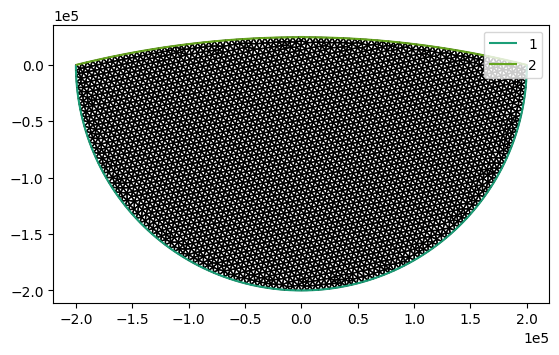

In [7]:
import icepack.plot
import matplotlib.pyplot as plt

fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
axes.legend();

In the demos for real glaciers that follow, we use all of the same tools.
The main difference is that the boundary arcs are drawn by hand in a geographic information system, rather than defined programatically in Python.
In the repository [glacier-meshes](https://github.com/icepack/glacier-meshes) I've included shapefiles of the outlines of several glaciers and a program to automate the translation of a shapefile into a .geo file using pygmsh.
This will be used in the demo for the Larsen Ice Shelf.

### Input data

To mimic the state of a real ice shelf, we'll pick a few angles along the inflow boundary that represent the centerlines of the ice streams that feed the shelf.
We'll then define velocity and thickness profiles along this inflow boundary.
We don't have a great idea from the outset of what the steady state of the ice shelf is; it doesn't have a simple analytical expression in terms of the coordinates.
Instead, we'll pick a somewhat arbitrary initial profile and evolve it towards steady state.

Many ice shelves (Larsen, Ross, etc.) have several streams feeding them.
Our synthetic glacier will be fed by four streams.
We'll define the inlets by picking the angles around the inflow boundary where each inlet comes in from and the width in radians.
You can re-run this notebook and change the values or the number of streams to whatever you like.

In [8]:
import numpy as np
from numpy import pi as π

inlet_angles = π * np.array([-3/4, -1/2, -1/3, -1/6])
inlet_widths = π * np.array([1/8, 1/12, 1/24, 1/12])

Next, we'll come up with some rather arbitrary and un-physical input data.
The basic idea is to make the thickness slope down as you go towards the calving terminus and away from the centerline of an inlet.
Likewise the ice speed goes up as you go towards the calving terminus.
We'll create a list of the perturbation thickness and velocity for each inlet and combine them all together at the end.
See again the 0th demo for how to create bumps, ramps, and other building blocks for synthesizing fields with a desired spatial pattern.

In [9]:
from firedrake import inner, as_vector

x = firedrake.SpatialCoordinate(mesh)

u_in = 300
h_in = 350
hb = 100
dh, du = 400, 250

hs, us = [], []
for θ, ϕ in zip(inlet_angles, inlet_widths):
    x0 = R * as_vector((np.cos(θ), np.sin(θ)))
    v = -as_vector((np.cos(θ), np.sin(θ)))
    L = inner(x - x0, v)
    W = x - x0 - L * v
    Rn = 2 * ϕ / π * R
    q = firedrake.max_value(1 - (W / Rn)**2, 0)
    hs.append(hb + q * ((h_in - hb) - dh * L /R))
    us.append(firedrake.exp(-4 * (W/R)**2) * (u_in + du * L / R) * v)

To combine the expressions for the thickness and velocity of each inlet into expressions for the whole ice shelf, we'll take the maximum thickness at any point, and the sum of the velocities.

In [10]:
h_expr = firedrake.Constant(hb)
for h in hs:
    h_expr = firedrake.max_value(h, h_expr)
    
u_expr = sum(us)

These are merely algebraic expressions.
To start modeling we need to interpolate these expressions to some function spaces defined over the mesh.

In [11]:
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(u_expr, V)

The algebra might be a little opaque, but the plots of the initial data should be more illuminating.

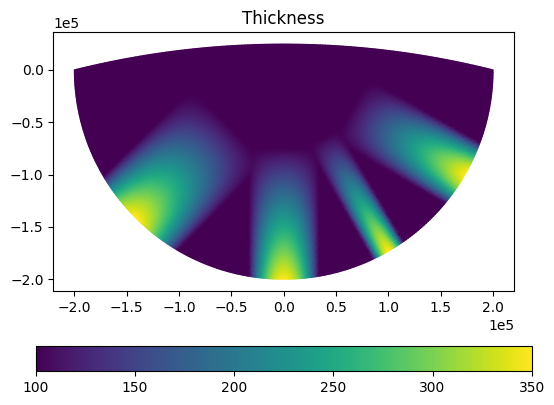

In [12]:
fig, axes = icepack.plot.subplots()
axes.set_title("Thickness")
colors = firedrake.tripcolor(h0, axes=axes)
fig.colorbar(colors, orientation="horizontal");

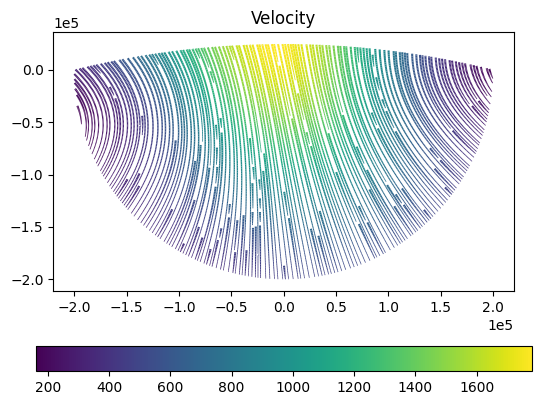

In [13]:
fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
streamlines = firedrake.streamplot(u0, resolution=2e3, axes=axes)
fig.colorbar(streamlines, orientation="horizontal");

As the simulation progresses, the ice streams, as represented by areas with higher thickness, will spread and grow.

### Modeling

To actually start solving things, we need to make two objects.
First, the class `IceShelf` represents what physics problem we're interested in.
In later tutorials we'll show how to alter the components of a particular physics model and how to use other models entirely.

In [14]:
import icepack

model = icepack.models.IceShelf()

Second, the class `FlowSolver` decides how we're going to solve that problem.
When we initialize the flow solver we pass it any arguments that never change throughout a simulation.
For example, the parts of the domain boundary where we apply Dirichlet boundary conditions have to stay the same throughout the whole simulation, and the list of those boundary IDs is passed in the keyword argument `dirichlet_ids`.

In [15]:
solver = icepack.solvers.FlowSolver(model, dirichlet_ids=[1])

The main job of the flow solver object is to solve the PDEs for ice velocity and thickness, for which it has two methods, `diagnostic_solve` and `prognostic_solve`.
These two methods are all that you need to describe the evolution of an ice shelf.

We need one more input variable, the fluidity factor $A$ in Glen's flow law $\dot\varepsilon = A\tau^3$.
The fluidity depends on several variables, especially the temperature of the ice; warmer ice is easier to deform.
For now we'll use a fluidity that comes from a spatially constant temperature of -18C.
The code itself assumes that all temperatures are in Kelvin.
At the end of this demo, we'll show how to incorporate the effect of ice damage on the fluidity.

In [16]:
T = firedrake.Constant(255.15)
A = icepack.rate_factor(T)

To compute the velocity field, we'll call the diagnostic solve method of the ice shelf object.
This method takes in the thickness, the fluidity factor $A$, and the initial guess for the ice velocity.
The keywords we use for these fields are exactly the same as their names.

In [17]:
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    fluidity=A,
)

The following plot shows streamlines of the velocity field.
These kind of plots are useful for showing areas of convergence and divergence of the flow field.

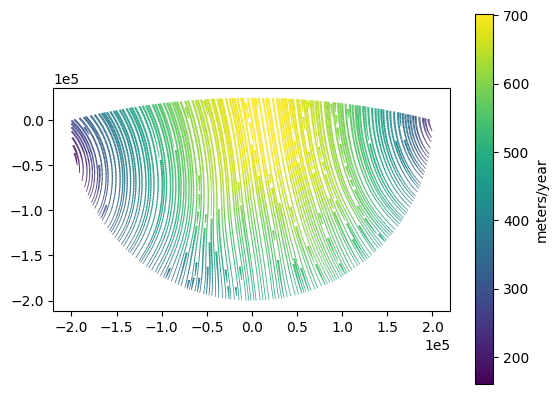

In [18]:
fig, axes = icepack.plot.subplots()
streamlines = firedrake.streamplot(u, resolution=2e3, axes=axes)
fig.colorbar(streamlines, label="meters/year");

To project the state of the ice shelf forward in time, we'll use the prognostic solve method.
The prognostic solver updates the ice thickness forward by a given timestep given the accumulation rate and velocity.
We then update the velocity using the diagnostic solver at each timestep.
The following code runs the model forward for several years until the ice shelf is roughly in steady state.

In [19]:
import tqdm

final_time = 400.
num_timesteps = 200
dt = final_time / num_timesteps
a = firedrake.Constant(0.0)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness=h, 
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        fluidity=A,
    )

100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


The main loop to run the simulation consists of alternating calls to the prognostic and diagnostic solve methods of the model object.
We saw this pattern in the ice sheet demo, and we'll see it repeated in all of the demos that follow.
In some cases we'll add in extra physics, like updating the temperature or damage field, but the core idea is the same.

Because repetition can be helpful, here are some notes we also made in the ice sheet demo.

**All of the fields involved in this simulation -- the ice thickness, velocity, and so forth -- were passed by keyword.**
Only the timestep `dt` was passed by position.
This is true more broadly of every solving routine in icepack.
Passing arguments by keyword is admittedly more verbose than passing them by position, but we've made this choice for an important reason.
As we'll show later on in this demo, passing arguments by keyword makes it possible to swap out components of the model physics for your own customized versions.
This flexibility would be impossible if we passed these fields by position.
Finally, keyword arguments save you the trouble of remembering what order everything goes in; you only have to remember their names.

As a typographical convenience, we've put every argument on its own line.
This isn't strictly necessary and you can adopt whatever convention you like for indenting your own code.
We've found that using a separate line for each argument when calling really important functions makes them stand out visually, and makes it easiest to quickly scan over the argument list.

We've added a progress bar using the package [tqdm](https://tqdm.github.io/) to give a bit of feedback about how long the simulation will take.
These kinds of diagnostics are helpful to know that the simulation is actually running and that it hasn't frozen.
But you can also put in whatever extra code you want here.
For example, you might want to make plots of the thickness and velocity, print out some physical quantity like the total flux of ice out of the calving front, or accumulate the fields into a list so that you can analyze the entire time series later.

To wrap things up, we'll make a plot of the final ice thickness and velocity.
The initial thickness profile of each ice stream, which flattened out in the middle of the shelf, has extended all the way to the terminus.

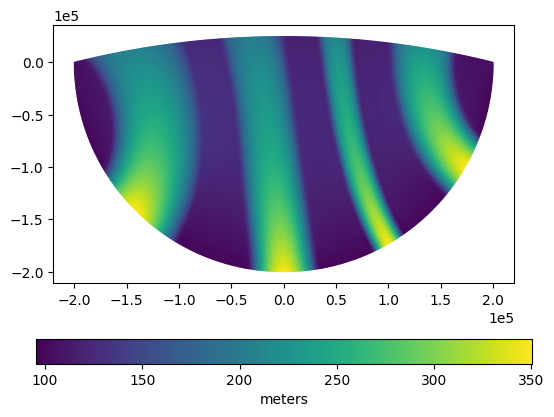

In [20]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(h, axes=axes)
fig.colorbar(colors, label="meters", orientation="horizontal");

A stream plot of the ice velocity shows that the areas of greatest flow divergence have moved around relative to the initial velocity.

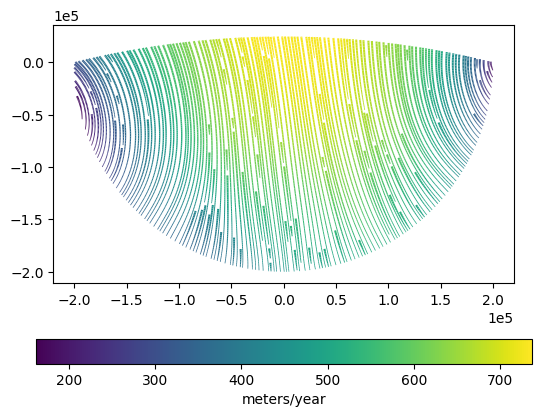

In [21]:
fig, axes = icepack.plot.subplots()
streamlines = firedrake.streamplot(u, resolution=2e3, axes=axes)
fig.colorbar(streamlines, label="meters/year", orientation="horizontal");

A useful quantity to know is how much ice is moving through the system.
In the first demo on meshes and functions, we showed how to symbolically create functionals of the solution.
We can use this to calculate the total ice flux through the calving terminus.

In [22]:
from firedrake import ds

ν = firedrake.FacetNormal(mesh)
flux = h * inner(u, ν) * ds(2)

The extra argument to `ds` indicates that we want to integrate over just the calving terminus rather than over the entire domain boundary.
The variable `flux` is a symbolic representation of this quantity in terms of the input fields; it isn't a number but rather a description of how to compute a number.
The function `firedrake.assemble` does the actual work of evaluating the integral.

In [23]:
print(f"Flux: {firedrake.assemble(flux) / 1e9} km^3 / year")

Flux: 38.109615881763254 km^3 / year


To check the degree to which the system really is in steady state, we can compute the flux along the inflow boundary rather than along the terminus.
This should be equal to the flux out of the domain since we've set the accumulation rate to be zero.

In [24]:
influx = -h * inner(u, ν) * ds(1)
print(f"Influx: {firedrake.assemble(influx) / 1e9} km^3 / year")

Influx: 38.14282902796044 km^3 / year


The influx and outflux are reasonably close, with the influx slightly exceeding the outflux.
The ice shelf will thicken, increasing the flux out of the terminus, until the two values equilibrate.

### Conclusion

In the last demo, we saw how to model a synthetic ice sheet.
Here we've shown a different example by modeling a synthetic ice shelf.
If you want to experiment with this example a bit more, you can run this notebook yourself and:

* change the curvature of the inflow boundary or the calving terminus
* change the stream widths, thicknesses, or velocities
* add a sinusoidal variation in the accumulation rate to approximate seasonal cycles

In the next demo, we'll show how to use these functions for simulating a real ice shelf in the Antarctic Peninsula using observational data from satellites.
As a bonus epilogue to this demo, we'll show how to also include the physics of damage and crevassing.

### Epilogue: Damage

The simulation we just ran uses the prognostic and diagnostic model physics of ice shelf flow.
These models successively update the ice thickness and velocity.
We assumed that the ice rheology was constant in space in order to simplify things, but this is never true for real ice shelves.
Here we'll show how to add a model for how crevasses and rifts affect glacier flow.

As ice becomes more damaged, the same driving stress must be transferred through a smaller total cross-sectional area of the ice.
We can incorporate the effect of crevasses and rifts into large-scale models of glacier velocity by increasing the fluidity of the ice column.
The extent of the damage is quantified in a scalar field $D$ which takes values between 0 (undamaged) and 1 (completely damaged).
Following [Albrecht and Levermann](https://doi.org/10.3189/2012JoG11J191), we define the damaged rate factor $A_D$ to be

$$A_D = (1 - D)^{-n}A(T)$$

where $n = 3$ is the Glen flow law exponent and $A(T)$ is the rate factor for undamaged ice at temperature $T$.
As the damage field approaches is maximum value of 1, the fluidity goes to infinity.
A large-scale calving event would occur before this limit is reached for a real glacier, but we won't include this effect here.

The ice shelf model includes several functions for calculating the net power dissipation of the ice shelf.
The velocity that solves the diagnostic equations minimizes this power dissipation functional.
To incorporate damage, we need to create our own function that calculates the viscous power dissipation in the presence of damage.
The default function to calculate the viscous power dissipation lives in the module `icepack.models.viscosity`, so all we need to do is pass the damaged fluidity $(1 - D)^{-n}\cdot A$ instead of just $A$ itself.

In [25]:
from icepack.constants import glen_flow_law as n
from icepack.models.viscosity import viscosity_depth_averaged

def viscosity_damaged(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    A = kwargs["fluidity"]
    D = kwargs["damage"]
    return viscosity_depth_averaged(
        velocity=u,
        thickness=h,
        fluidity=(1 - D)**(-n) * A,
    )

We can then create a new ice shelf model object and solver that will use `viscosity_damaged` to calculate the power dissipation instead of the default.

In [26]:
flow_model = icepack.models.IceShelf(viscosity=viscosity_damaged)
flow_solver = icepack.solvers.FlowSolver(flow_model, dirichlet_ids=[1])

The procedure is exactly the same to modify any other part of the physics of any model.
For example, you could also change how the back-pressure at the calving terminus is computed in order to account for the presence of ice melange.
In later tutorials, we'll look at alternative models for basal friction, and we'll swap out the model physics in exactly the same way.

So far, we've decided how to incorporate damage into the diagnostic model for the ice velocity.
We also need some rule for how damage will evolve.
One approach would be to use fracture mechanics to explicitly model individual crevasses, but this approach would be very computationally expensive.
Instead, the *continuum damage mechanics* approximation posits that there is some bulk transport law for damage that looks something like this:

$$\frac{\partial D}{\partial t} + u\cdot\nabla D = f_o - f_c$$

where $f_o$ is a crevasse opening term and $f_c$ is a crevasse closing or healing term.
Crevasses open when the stress is sufficiently high, and crevasses close when the strain rate is low or compressional.
The real physics comes in deciding the exact details of how these terms depend on the stress, strain rate, and other variables.
In the following, we'll use the model from [Albrecht and Levermann](https://doi.org/10.3189/2012JoG11J191), but there are many others.

A key feature of the damage model we'll use is that the sources of damage depend on the stress and strain rate of the flow field and we need to explicitly supply these variables as inputs.
These fields are both rank-2 tensors (which is sort of a fancy way of saying a matrix).
We need to first create a function space to represent them.
Next we'll use some of the symbolic functions that Firedrake gives us in order to calculate the strain rate tensor.

In [27]:
from firedrake import sym, grad, sqrt, tr

S = firedrake.TensorFunctionSpace(mesh, "DG", 1)
ε = firedrake.project(sym(grad(u)), S)

At this juncture we'd like to make a plot of the strain rate field, but since it's a tensor, doing that is a little challenging.
Here we've taken the easy way out and plotted the effective strain rate, which is the only quantity that actually matters for the damage mechanics model.
You could also plot, say, the component of the strain rate tensor along or across the flow direction if you wanted more fine-grained details.
The strain rate has units of inverse time, which is a little hard to grasp.
I find it's most helpful to think of this in terms of how much speed the ice can gain in meters per year over a distance in kilometers, which is the unit system we've used for the color bar below.

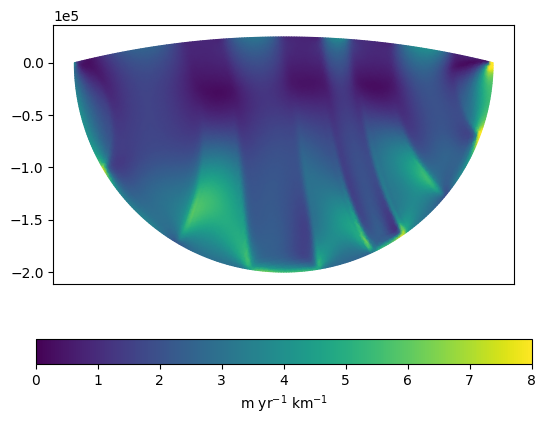

In [28]:
ε_e = firedrake.project(1e3 * sqrt(inner(ε, ε) + tr(ε) ** 2), Q)

fig, axes = icepack.plot.subplots()
axes.get_xaxis().set_visible(False)
colors = firedrake.tripcolor(ε_e, vmin=0, vmax=8, axes=axes)
fig.colorbar(
    colors, orientation="horizontal", label="m yr${}^{-1}$ km${}^{-1}$"
)

One of the interesting things you can observe in this plot is how much higher the strain rate is *between* the ice streams rather than within them.

The class `icepack.models.DamageTransport` describes the damage transport law, while `icepack.solvers.DamageSolver` contains routines for actually solving it.
We'll initialize the damage field to be zero everywhere and we'll advect in zero damage from upstream.

In [29]:
damage_model = icepack.models.DamageTransport()
damage_solver = icepack.solvers.DamageSolver(damage_model)

Δ = firedrake.FunctionSpace(mesh, "DG", 1)
D = firedrake.Function(Δ)

Next, we'll run a new simulation that includes interleaved updates for ice thickness and velocity, just like before, but also an update for the damage field according to the transport law we wrote down above.
The simulation will go for long enough to propagate the damage field through an entire residence time of the ice shelf.

There are a few new things about this simulation loop compared to what we showed above.
First, the diagnostic solve procedure now takes the damage field as a keyword argument in addition to the other fields we've already seen.
We then have to calculate the strain rate and membrane stress tensors, since these are the sources of damage.
Finally, there's another update for the damage field.

We're also explicitly telling the form compiler what quadrature dgree to use when we calculate the membrane stress tensor.
Firedrake defaults to a large number of quadrature points in order to evaluate that integral as exactly as it can.
But it will also throw a warning if an expression is so complicated that it requires too many quadrature points.
Passing the degree explicitly silences the warning and makes the code run faster without much accuracy loss.

In [30]:
from icepack.models.viscosity import membrane_stress

degree = D.ufl_element().degree() + 2 * ε.ufl_element().degree()
params = {
    "form_compiler_parameters": {
        "quadrature_degree": degree
    }
}

ε = firedrake.Function(S)
M = firedrake.Function(S)

for step in tqdm.trange(num_timesteps):
    h = flow_solver.prognostic_solve(
        dt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )

    u = flow_solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        fluidity=A,
        damage=D,
    )

    ε.project(sym(grad(u)))
    expr = (1 - D) * membrane_stress(strain_rate=ε, fluidity=A)
    M.project(expr, **params)

    D = damage_solver.solve(
        dt,
        damage=D,
        velocity=u,
        strain_rate=ε,
        membrane_stress=M,
        damage_inflow=firedrake.Constant(0.0),
    )

100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


To use the damage model, you (the user) have to add some code to calculate the strain rate and membrane stress tensors.
This is a general feature of icepack: we'll implement the solvers and you provide the forcing terms.
This approach does involve some extra work on your part.
But we've found that giving users this level of control over feedbacks between different processes is essential.

Finally we'll plot the result.
When we plotted the strain rate before, we found elevated values between the ice streams.
While there is a band of high ice damage in between the the two streams on the left, the other two margins show relatively little damage at all despite strain rates that are lower but not significantly so.
We see this feature in the solution occurs because the source terms in the damage model are only activated once the stress exceeds a certain threshold.

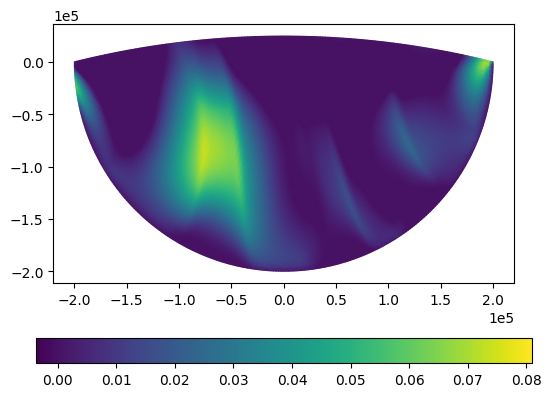

In [31]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(D, axes=axes)
fig.colorbar(colors, orientation="horizontal");

If you want to experiment with this problem further, you can try:

* changing the parameters of the damage model, such as the critical stress at which damage grows; see `DamageTransport.__init__` for a full list and the default values
* changing the inflow velocities of each ice stream; the larger the speed contrasts between neighboring streams, the greater the damage between them
* adding an ice rise to the domain to see how shear around this obstacle affects damage.

Damage mechanics is one of many things you might want to simulate in order to accurately capture the physics of glacier flow.
In later demos, we'll show how to incorporate heat transfer.
We could also include models describing things like the buoyant plume of meltwater in the top layer of ocean underneath the ice shelf, or the densification of firn on the ice surface.
The details are different in each case, but the essential procedure is the same: first decide how the addition of a new field will affect the flow, and then decide how this field will evolve in time.
We used the continuum damage formulation of Albrecht and Levermann, but there are many other models we could have chosen.